Run PCA on different model neural population trajectories generated by natural song

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal

from aux import zscore
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

NRL_MDLS = ['lin', 'ln', 'dyn']
COLORS = ['b', 'm', 'k']
FPCAS = [
    f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_pca_nm91_zh23/pca_results.npy'
    for nrl_mdl in NRL_MDLS
]

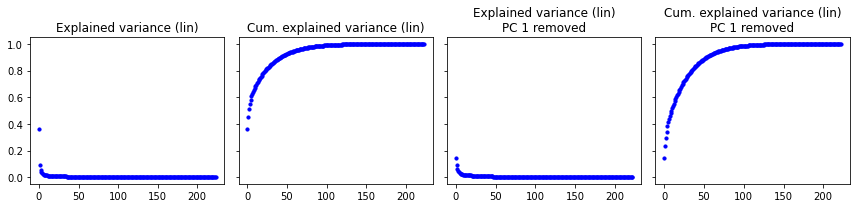

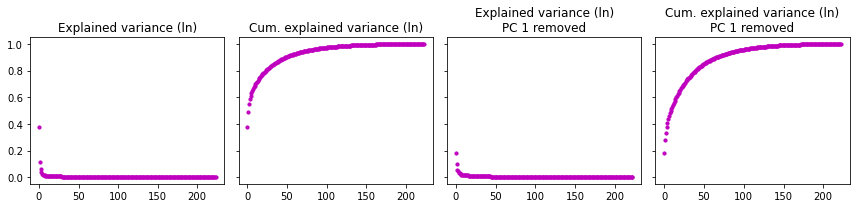

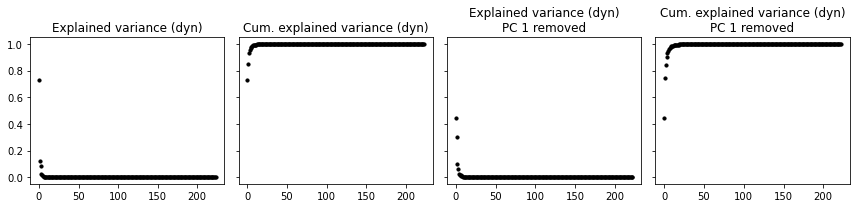

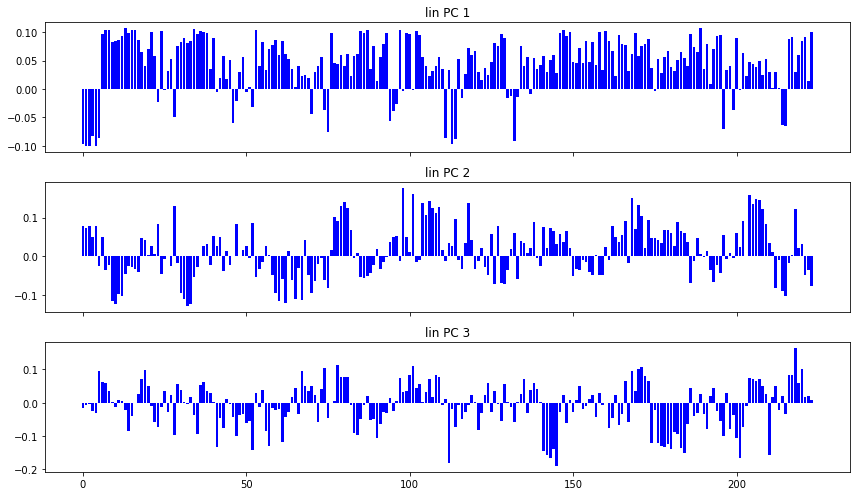

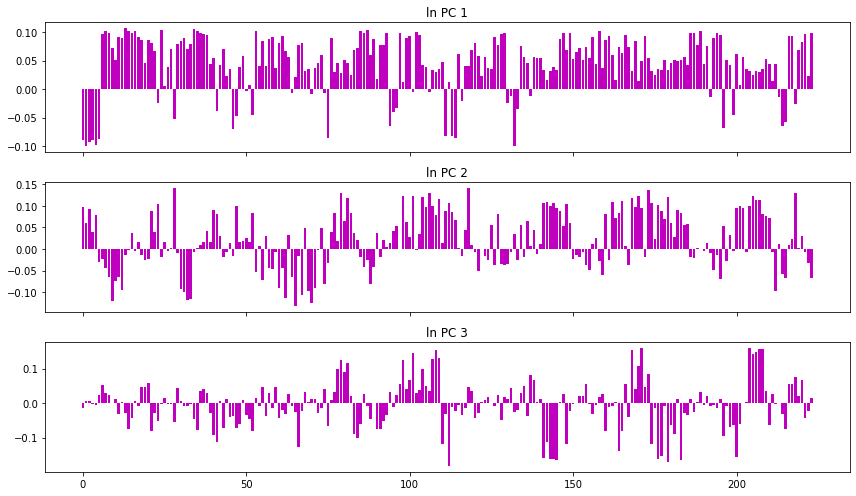

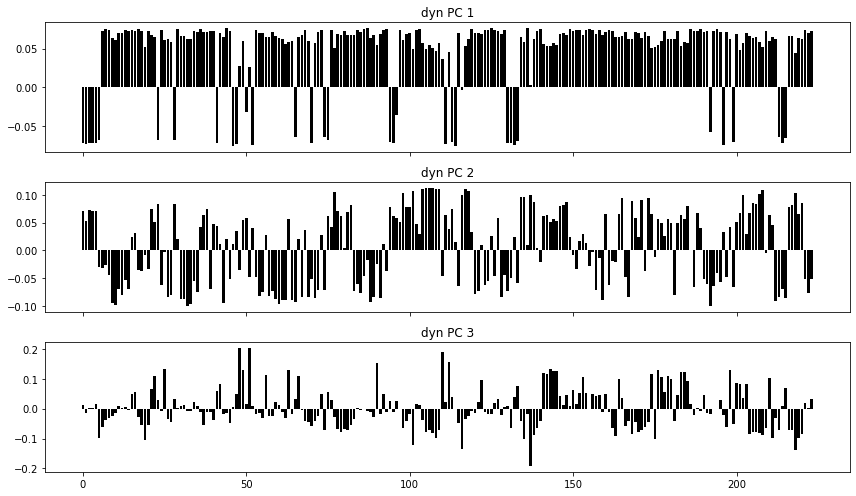

In [2]:
# plot PCA eigenspectra results for each nrl mdl
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True, sharey=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    expl_var = pca_rslt['expl_var']
    axs[0].scatter(np.arange(len(expl_var)), expl_var, s=10, c=color)
    axs[0].set_title(f'Explained variance ({nrl_mdl})')
    axs[1].scatter(np.arange(len(expl_var)), expl_var.cumsum(), s=10, c=color)
    axs[1].set_title(f'Cum. explained variance ({nrl_mdl})')
    
    expl_var_no_pc_1 = expl_var[1:]
    expl_var_no_pc_1 /= expl_var_no_pc_1.sum()
    
    axs[2].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1, s=10, c=color)
    axs[2].set_title(f'Explained variance ({nrl_mdl})\nPC 1 removed')
    axs[3].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1.cumsum(), s=10, c=color)
    axs[3].set_title(f'Cum. explained variance ({nrl_mdl})\nPC 1 removed')
    
# plot top PCs for each nrl mdl
top_pcs = {}
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(3, 1, figsize=(12, 7), tight_layout=True, sharex=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    
    for cpc, ax in enumerate(axs):
        ax.bar(np.arange(NR), pca_rslt['pcs'][cpc, :], color=color)
        ax.set_title(f'{nrl_mdl} PC {cpc+1}')
    
    top_pcs[nrl_mdl] = pca_rslt['pcs'][:4, :]

# Project example song responses onto PCs of different models

In [3]:
from disp import trj_2d

In [4]:
DF_LIN_PARAM = pd.read_csv('data/simple/neur/baker_lin_fit_param.csv')
DF_LN_PARAM = pd.read_csv('data/simple/neur/baker_ln_fit_param.csv')
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

EXPT_IDS = DF_LIN_PARAM['EXPT_ID']

In [5]:
# linear simulation
# filters (downsampled)
hs_lin_dn_s = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_lin_dn_p = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_lin_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_s])[:-1]) for h_lin_dn_s in hs_lin_dn_s])
hs_lin_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_p])[:-1]) for h_lin_dn_p in hs_lin_dn_p])

def smlt_lin_(i_s, i_p, h_s, h_p):
    """Single neuron"""
    r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
        + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    return r


def smlt_lin(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p) in enumerate(zip(hs_lin_s, hs_lin_p)):
        rs[:, cr] = smlt_lin_(i_s, i_p, h_s, h_p)
        
    return rs


# linear-nonlinear simulation
# filters (downsampled)
hs_ln_dn_s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_ln_dn_p = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_ln_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_s])[:-1]) for h_ln_dn_s in hs_ln_dn_s])
hs_ln_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_p])[:-1]) for h_ln_dn_p in hs_ln_dn_p])

r_mins = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MIN'] for expt_id in EXPT_IDS])
r_maxs = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MAX'] for expt_id in EXPT_IDS])
z_0s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['Z_0'] for expt_id in EXPT_IDS])
betas = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['BETA'] for expt_id in EXPT_IDS])

def smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Single neuron."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


def smlt_ln(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p, r_min, r_max, z_0, beta) in enumerate(zip(hs_ln_s, hs_ln_p, r_mins, r_maxs, z_0s, betas)):
        rs[:, cr] = smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        
    return rs


# nonlinear adaptive simulation
tau_rs = np.array(DF_DYN_PARAM['TAU_R'])
tau_as = np.array(DF_DYN_PARAM['TAU_A'])
x_ss = np.array(DF_DYN_PARAM['X_S'])
x_ps = np.array(DF_DYN_PARAM['X_P'])

def smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

def smlt_dyn(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (tau_r, tau_a, x_s, x_p) in enumerate(zip(tau_rs, tau_as, x_ss, x_ps)):
        rs[:, cr] = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
    return rs

In [6]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return t, sng.astype(int)

    
from disp import plot_b
colors_1 = ['gray', 'b', 'r']
colors_2 = ['gray', 'dodgerblue', 'salmon']

def plt_rsps(grp, rsps, x_pc, y_pc):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), tight_layout=True, sharex=True, sharey=True)
    for csng, (t, sng) in enumerate(grp):
        colors = [colors_1, colors_2][csng]
        plot_b(axs[0], t, sng, [0, t.max()+DT, 4*csng, 4*csng + 2], c=colors_1)
        
        r_lin = rsps[csng]['lin']
        r_ln = rsps[csng]['ln']
        r_dyn = rsps[csng]['dyn']
        
        trj_2d(axs[1], t, r_lin[:, x_pc], r_lin[:, y_pc], sng, c=colors, s_max=50)
        trj_2d(axs[2], t, r_ln[:, x_pc], r_ln[:, y_pc], sng, c=colors, s_max=50)
        trj_2d(axs[3], t, r_dyn[:, x_pc], r_dyn[:, y_pc], sng, c=colors, s_max=50)
        
    axs[1].set_title('LIN response')
    axs[2].set_title('LN response')
    axs[3].set_title('DYN response')
    
    axs[0].set_xlabel('Time (s)')
    for ax in axs[1:]:
        ax.scatter([0], [0], marker='^', c='k')
        set_plot(ax, x_label=f'PC {x_pc+1}', y_label=f'PC {y_pc+1}')

In [7]:
sngs = []

# single song elements
grp = [
    make_sng(10, s=[(0, 10)]),
    make_sng(10, p=[(0, 10)]),
]
sngs.append(grp)

# 1 switch, balanced
grp = [
    make_sng(10, s=[(0, 5)], p=[(5, 10)]),
    make_sng(10, s=[(5, 10)], p=[(0, 5)]),
]
sngs.append(grp)

# 1 switch, unbalanced
grp = [
    make_sng(10, s=[(0, 2)], p=[(2, 10)]),
    make_sng(10, s=[(8, 10)], p=[(0, 8)]),
]
sngs.append(grp)

# reversed from previous group
grp = [
    make_sng(10, s=[(2, 10)], p=[(0, 2)]),
    make_sng(10, s=[(0, 8)], p=[(8, 10)]),
]
sngs.append(grp)

# medium switches
grp = [
    make_sng(4, s=[(0, .5), (1, 1.5), (2, 2.5), (3, 3.5)], p=[(.5, 1), (1.5, 2), (2.5, 3), (3.5, 4)]),
]
sngs.append(grp)

grp = [
    make_sng(4, p=[(0, .5), (1, 1.5), (2, 2.5), (3, 3.5)], s=[(.5, 1), (1.5, 2), (2.5, 3), (3.5, 4)]),
]
sngs.append(grp)

# fast switches
grp = [
    make_sng(4,
        s=[(0, .25), (.5, .75), (1, 1.25), (1.5, 1.75), (2, 2.25), (2.5, 2.75), (3, 3.25), (3.5, 3.75)],
        p=[(.25, .5), (.75, 1.), (1.25, 1.5), (1.75, 2), (2.25, 2.5), (2.75, 3), (3.25, 3.5), (3.75, 4)]),
]
sngs.append(grp)

grp = [
    make_sng(4,
        p=[(0, .25), (.5, .75), (1, 1.25), (1.5, 1.75), (2, 2.25), (2.5, 2.75), (3, 3.25), (3.5, 3.75)],
        s=[(.25, .5), (.75, 1.), (1.25, 1.5), (1.75, 2), (2.25, 2.5), (2.75, 3), (3.25, 3.5), (3.75, 4)]),
]
sngs.append(grp)

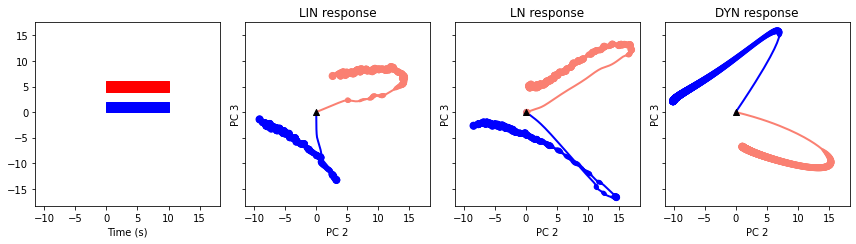

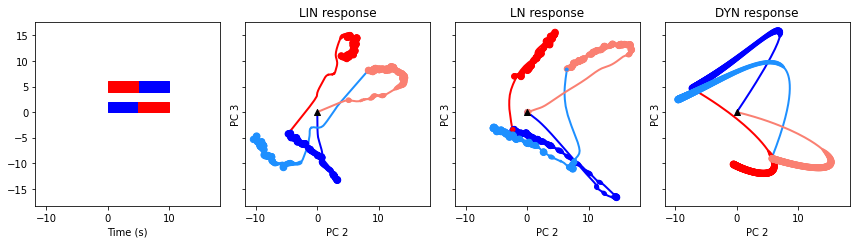

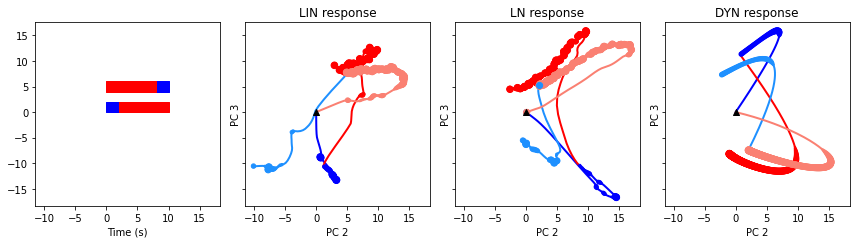

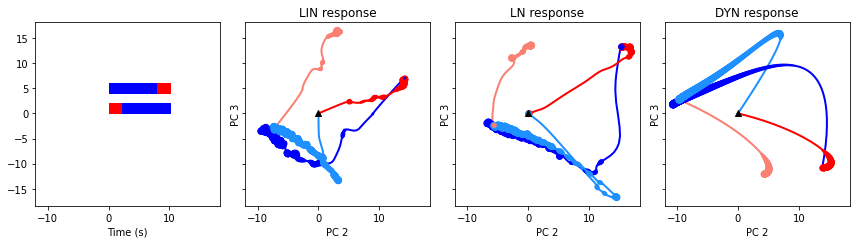

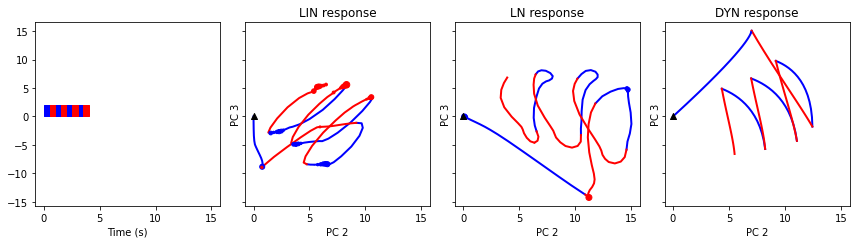

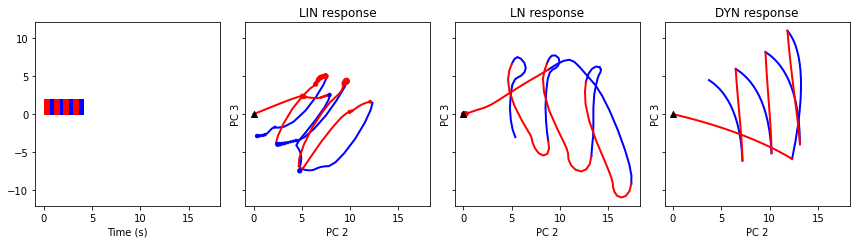

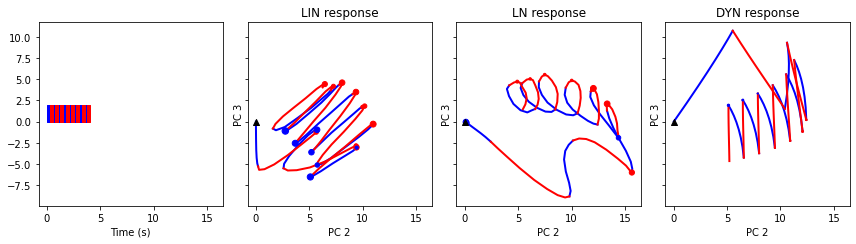

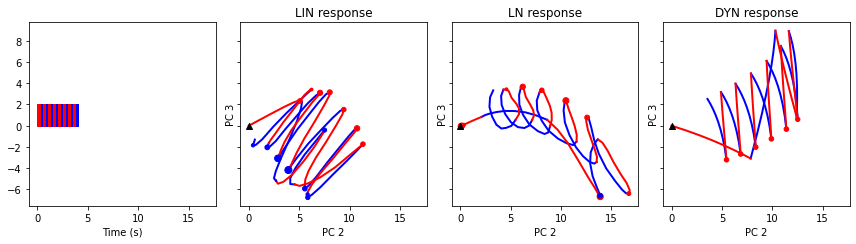

In [8]:
# compute responses of different neural models
rsps_all = []

for grp in sngs:
    rsps = []
    for t, sng in grp:
        r_lin = smlt_lin(sng) @ top_pcs['lin'].T
        r_ln = smlt_ln(sng) @ top_pcs['ln'].T
        r_dyn = smlt_dyn(sng) @ top_pcs['dyn'].T
        rsps.append({'lin': r_lin, 'ln': r_ln, 'dyn': r_dyn})
        
    rsps_all.append(rsps)
    
for grp, rsps in zip(sngs, rsps_all):
    plt_rsps(grp, rsps, x_pc=1, y_pc=2)

In [9]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]

(100.0, 160.0)

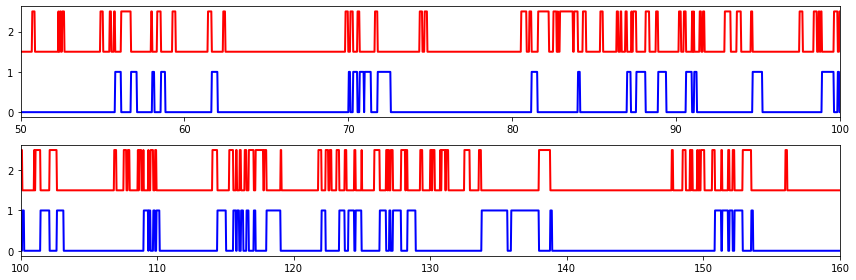

In [10]:
df_tr = df_song[df_song['ID'] == 0]
q = np.array(df_tr['Q'])
s = np.array(df_tr['S'])
p = np.array(df_tr['P'] | df_tr['F'])

fig, axs = plt.subplots(2, 1, figsize=(12, 4), tight_layout=True)
for ax in axs:
    ax.plot(df_tr['T'], s, lw=2, c='b')
    ax.plot(df_tr['T'], p+1.5, lw=2, c='r')
    
axs[0].set_xlim(50, 100)
axs[1].set_xlim(100, 160)

In [11]:
wdws = [(50, 60), (69, 75), (80, 95), (122, 140), (148, 155)]
wdws = [(50, 55), (69, 74), (80, 85), (122, 127), (148, 153), (138, 143), (107, 112)]

In [12]:
sngs = []

for wdw in wdws:
    mt = (wdw[0] <= df_tr['T']) & (df_tr['T'] < wdw[1])
    t = np.arange(mt.sum())*DT
    sng = np.zeros(len(t))
    sng[s[mt] == 1] = 1
    sng[p[mt] == 1] = 2
    sngs.append([(t, sng.astype(int))])

In [13]:
# compute responses of different neural models
rsps_all = []

for grp in sngs:
    rsps = []
    for t, sng in grp:
        r_lin = smlt_lin(sng) @ top_pcs['lin'].T
        r_ln = smlt_ln(sng) @ top_pcs['ln'].T
        r_dyn = smlt_dyn(sng) @ top_pcs['dyn'].T
        rsps.append({'lin': r_lin, 'ln': r_ln, 'dyn': r_dyn})
        
    rsps_all.append(rsps)
    

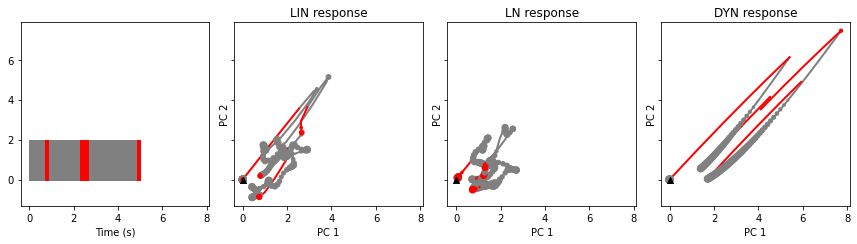

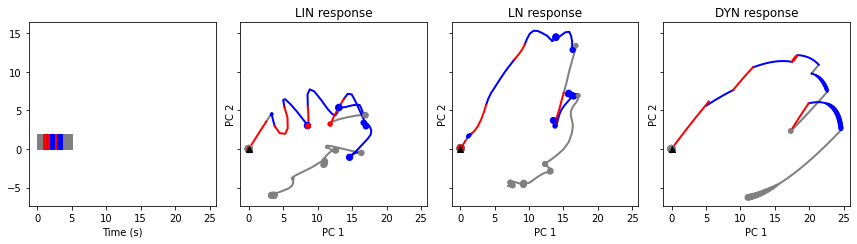

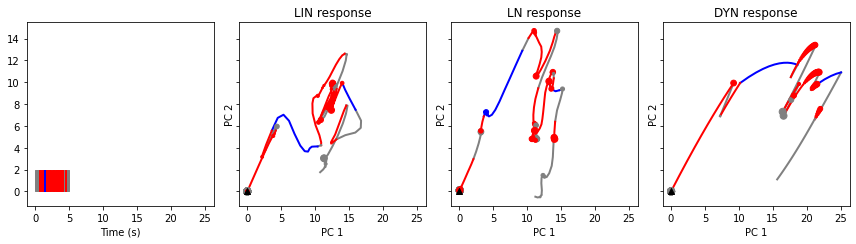

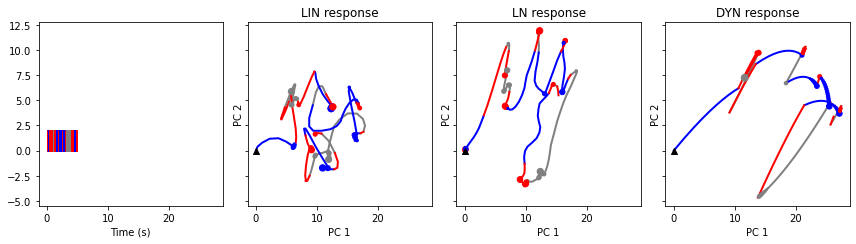

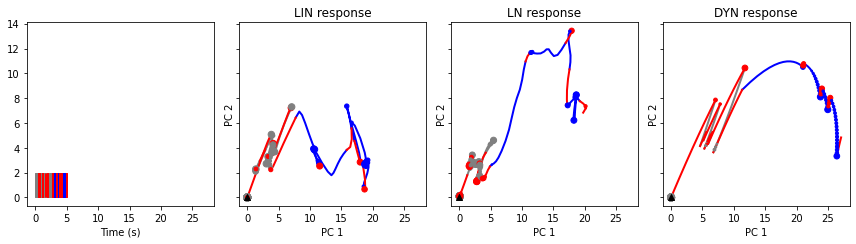

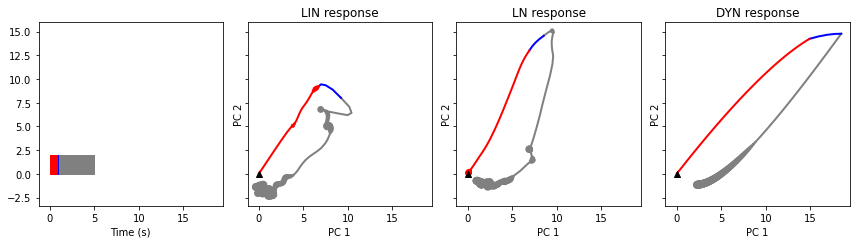

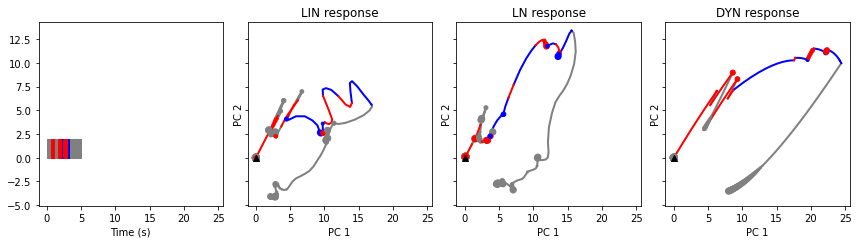

In [14]:
for grp, rsps in zip(sngs, rsps_all):
    plt_rsps(grp, rsps, x_pc=0, y_pc=1)

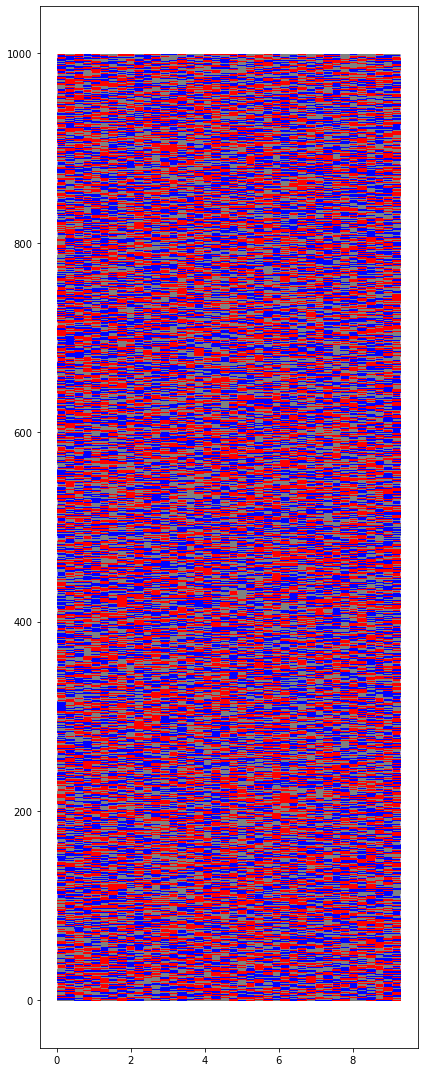

In [15]:
import editdistance

sngs = []
IT_SEG = 7
NSEG = 40
NSNG = 1000

t = np.arange(0, NSEG*IT_SEG*DT, DT)
for _ in range(NSNG):
    sng = []
    for iseg in range(NSEG):
        next_mode = np.random.randint(0, 3)
        sng.extend((IT_SEG*[next_mode]))
    sngs.append(np.array(sng).astype(int))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

In [16]:
sngs_str = [
    ''.join([str(x) for x in sng]) for sng in sngs
]
ds_hm = np.nan * np.zeros((NSNG, NSNG))  # hamming distance between songs
ds_lv = np.nan * np.zeros((NSNG, NSNG))  # levenshtein distance between songs


for i in range(NSNG):
    for j in range(i+1, NSNG):
        d_hm = np.sum(sngs[i] != sngs[j])
        ds_hm[i, j] = d_hm
#         ds_hm[j, i] = d_hm
        
        d_lv = editdistance.eval(sngs_str[i], sngs_str[j])
        ds_lv[i, j] = d_lv
#         ds_lv[j, i] = d_lv

Text(0, 0.5, 'Lev dist')

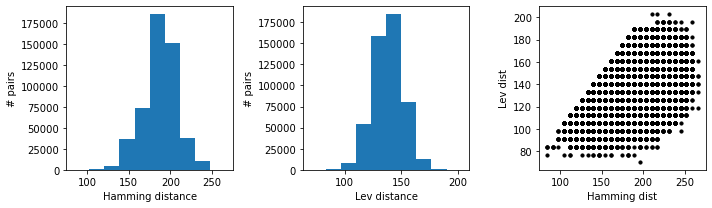

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
axs[0].hist(ds_hm.flatten(), bins=10)
axs[0].set_xlabel('Hamming distance')
axs[0].set_ylabel('# pairs')
axs[1].hist(ds_lv.flatten(), bins=10)
axs[1].set_xlabel('Lev distance')
axs[1].set_ylabel('# pairs')
axs[2].scatter(ds_hm.flatten(), ds_lv.flatten(), s=10, c='k')
axs[2].set_xlabel('Hamming dist')
axs[2].set_ylabel('Lev dist')

In [18]:
# compute responses of different neural models
import sys
rsps = {nrl_mdl: np.nan*np.zeros((NSNG, 224)) for nrl_mdl in NRL_MDLS}

for csng, sng in enumerate(sngs):
    sys.stdout.write('.')
    r_lin = smlt_lin(sng)
    r_ln = smlt_ln(sng)
    r_dyn = smlt_dyn(sng)
    
    # save final timepoints
    rsps['lin'][csng, :] = r_lin[-1, :]
    rsps['ln'][csng, :] = r_ln[-1, :]
    rsps['dyn'][csng, :] = r_dyn[-1, :]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [19]:
# compute neural distances
# ds_nrl = {nrl_mdl: rsps[nrl_mdl]@rsps[nrl_mdl].T/NSNG for nrl_mdl in NRL_MDLS}
ds_nrl = {nrl_mdl: np.nan * np.eye(NSNG) for nrl_mdl in NRL_MDLS}

for nrl_mdl in NRL_MDLS:
    for i in range(NSNG):
        for j in range(i+1, NSNG):
            d_nrl = np.sqrt(np.mean((rsps[nrl_mdl][i, :] - rsps[nrl_mdl][j, :])**2))
            ds_nrl[nrl_mdl][i, j] = d_nrl
#             ds_nrl[nrl_mdl][j, i] = d_nrl

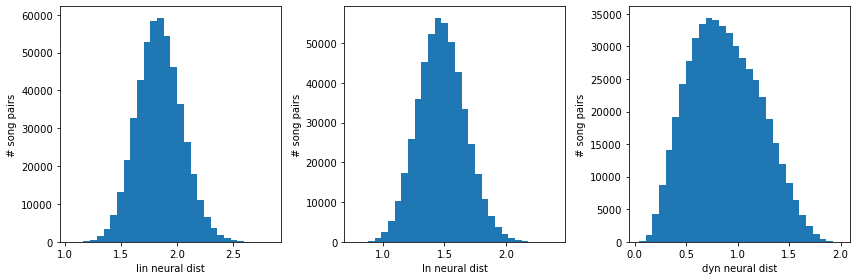

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for nrl_mdl, ax in zip(NRL_MDLS, axs):
    ax.hist(ds_nrl[nrl_mdl].flatten(), bins=30)
    ax.set_xlabel(f'{nrl_mdl} neural dist')
    ax.set_ylabel('# song pairs')

Text(0, 0.5, 'Levenshtein dist')

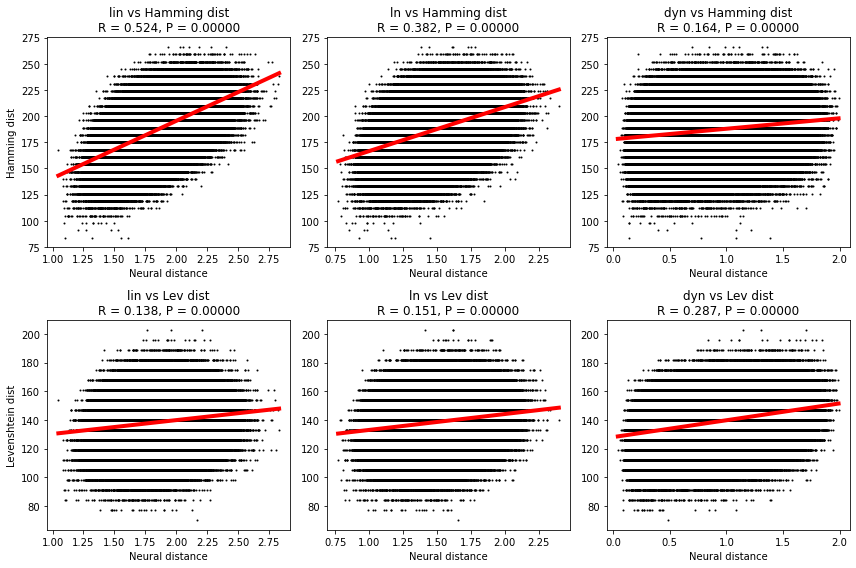

In [21]:
from disp import get_line

fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

for cnrl_mdl, nrl_mdl in enumerate(NRL_MDLS):
    axs[0, cnrl_mdl].scatter(ds_nrl[nrl_mdl].flatten(), ds_hm.flatten(), c='k', s=1)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl[nrl_mdl].flatten(), ds_hm.flatten())
    axs[0, cnrl_mdl].plot(x_ln, y_ln, c='r', lw=4)
    axs[0, cnrl_mdl].set_title(f'{nrl_mdl} vs Hamming dist\nR = {r:.3f}, P = {p:.5f}')
    axs[0, cnrl_mdl].set_xlabel('Neural distance')
    
    axs[1, cnrl_mdl].scatter(ds_nrl[nrl_mdl].flatten(), ds_lv.flatten(), c='k', s=1)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl[nrl_mdl].flatten(), ds_lv.flatten())
    axs[1, cnrl_mdl].plot(x_ln, y_ln, c='r', lw=4)
    axs[1, cnrl_mdl].set_title(f'{nrl_mdl} vs Lev dist\nR = {r:.3f}, P = {p:.5f}')
    axs[1, cnrl_mdl].set_xlabel('Neural distance')
    
    
    
axs[0, 0].set_ylabel('Hamming dist')
axs[1, 0].set_ylabel('Levenshtein dist')